<a href="https://colab.research.google.com/github/ladyDayana/Anomaly-Detection-Challenge/blob/main/Anomaly_Detection_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Challenge: "Handling gaps in time series dataset from temperature readings for the development of anomaly detection algorithm":

**Notebook Structure**:

1. Exploratory Data Analysis (EDA) of the provided dataset
  - Check Time Series Time range 
  - Data Distribution Analysis
  - Time Evolution of the Cooling and Heating temperatures
  - Visualization of Periodical Patterns
  - Visualization of the Heating and Cooling temperatures Relation
  - Selection of the Sampling period 
2. Proposal of a possible interpolation solution
4. Proposal of a possible anomaly detector model 



---



In [337]:
# Import python libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [300]:
# from google.colab import drive
# drive.mount('/content/drive')

In [301]:
# Install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [302]:
# Create Spark Session
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType
spark = SparkSession.builder.getOrCreate()

In [340]:
# Upload Dataset
from google.colab import files
# file_path = "/sample_temperature_data_for_coding_challenge.csv"
uploaded = files.upload()
for fn in uploaded.keys(): 
  file_path = '/content/' + fn

In [341]:
# Variables to be configured

expected_data_schema = "root\n |-- source_id: string (nullable = true)\n |-- datetime: timestamp (nullable = true)\n |-- property_name: string (nullable = true)\n |-- temperature: double (nullable = true)\n"

test_df = spark.createDataFrame(
    data = [ ("1","2019-04-13 17:51:16")],
    schema=["id","datetime"]).withColumn("datetime",to_timestamp("datetime"))

expected_df = spark.createDataFrame(
    data = [ ("1","2019-04-13 17:51:16", 2019, 4, "2019-04-13", "17:51", 1555177876, "Saturday")],
    schema=["id","datetime", "year", "month", "date", "time", "sec", "week_day"]) \
    .withColumn("datetime",to_timestamp("datetime")) \
    .withColumn("date",to_date("date")) \
    .withColumn("year",col("year").cast("int")) \
    .withColumn("month",col("month").cast("int")) \
    .withColumn("sec",col("sec").cast("bigint"))

In [304]:
# Simple quick Tests

def check_schema(file_path, expected_schema):
  """
  Check loaded spark dataframe has the expected schema
  """
  assert load_dataset(file_path)._jdf.schema().treeString() == expected_schema, "The schema was not correctly interpreted"

def check_extract_time_info(spark_dataframe, expected_spark_dataframe):
  """
  Check loaded spark dataframe has the expected schema
  """
  assert extract_time_info(spark_dataframe, "datetime").join(expected_spark_dataframe, expected_spark_dataframe.columns, 'outer').count() == 1, "The time info was not correctly extracted, please check you provided a timestamp column"

def check_count_rows(spark_dataframe, expected_count):
  """
  Check loaded spark dataframe has the expected schema
  """
  assert spark_dataframe.count() == expected_count, "The number of rows is not the expected one"

In [306]:
# Utils

def load_dataset(file_path, delimiter=",", header=True, inferschema=True, dateFormat="yyyy-MM-ddTHH:mm:ss", encoding="ISO-8859-1"):
  """
  Read the csv file as a spark dataframe

  Args:
      file_path (string) - csv file path
      delimiter (string) - csv delimiter
      header (boolean) - csv header
      inferschema (boolean) - flag to automatically infer schema
      dateFormat (string) - timestamp format
      encoding (string) - csv econding type

  Returns:
      spark_dataframe (sparkdataframe) - csv data as a spark dataframe  

  """
  spark_dataframe = spark_dataframe = spark.read.option("delimiter", ",") \
                      .option("header", True) \
                      .option("inferschema", "true") \
                      .option("dateFormat", "yyyy-MM-ddTHH:mm:ss") \
                      .option("encoding", "ISO-8859-1") \
                      .csv(file_path)
  return spark_dataframe


def extract_time_info(spark_dataframe, time_column):
  """
  Extract common time info from a timestamp column

  Args:
    spark_dataframe (sparkdataframe) - input spark dataframe
    time_column (string) - timestamp column name

  Returns:
      spark_dataframe (sparkdataframe) - spark dataframe with new time attributes  

  """
  spark_dataframe = spark_dataframe.withColumn("year", year(col(time_column))) \
                    .withColumn("year", year(col(time_column))) \
                    .withColumn("month", month(col(time_column))) \
                    .withColumn("date", to_date(col(time_column))) \
                    .withColumn("time", date_format(col(time_column), "HH:mm")) \
                    .withColumn("sec", unix_timestamp(col(time_column), "HH:mm")) \
                    .withColumn("week_day", date_format(col(time_column), "EEEE"))
  return spark_dataframe

  
def plot_hist(series, variables, bins=None, xlabel="Temperature", labels=["c", "h"], colors=["blue", "red"], align="mid", figwidth=15, figheight=6, alpha=0.5, weights=None):
    """
    Visualizes the histogram of a variable given a series of values

    Args:
      series (list of pandas dataframe) - series to plot
      variables (list of string) - variable name per each serie
      bins (int) - number of bins
      xlabel (string) - x axes label 
      format (string) - line style when plotting the graph
      labels (list of string)- tag for the line
      colors (list of string) - color of the points
      align (string) - bins position
      figwidth (int) - width of the window plot
      figheight (int) - height of the window plot
      alpha (float) - degree of points transparency

    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(figwidth, figheight))

    # Plot the time series data
    index = 0
    for series in series:
      # h_pd.h_tmp.hist(bins=None, align="mid", facecolor='r', alpha=0.5)
      series[variables[index]].hist(bins=bins, align=align, facecolor=colors[index], alpha=alpha, weights=weights)
      index+=1

    # Label the x-axis
    plt.xlabel("Temperature")
    
    # Set x values
    plt.xticks(ticks=range(14,41))

    # Label the y-axis
    plt.ylabel("Count")

    if labels:
        plt.legend(fontsize=14, labels=labels)

    # Overlay a grid on the graph
    plt.grid(True)
    plt.title('Measurements Histogram')
    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

    # Draw the graph on screen
    plt.show()

def plot_series(series, x, y, format="o", ylabel="Temperature", xlabel = "Time", colors=["blue", "red"], start=0, end=None, labels=["c", "h"], figwidth=30, figheight=10, alpha=0.5):
    """
    Visualize time series data

    Args:
      series (list of dataframe) - series to plot
      x (list of string) - x-axes column names
      y (list of string) - y-axes column names
      format (string) - line style when plotting the graph
      ylabel (string) - y axes label name
      xlabel (string) - x axes label name
      colors (list of string) - color of the points
      start (int) - first time step to plot
      end (int) - last time step to plot
      labels (list of strings)- tag for the lines
      figwidth (int) - width of the window plot
      figheight (int) - height of the window plot
      alpha (float) - degree of points transparency

    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(figwidth, figheight))

    # Plot the time series data
    index = 0
    for series in series:
      plt.plot(series[x[index]][start:end], series[y[index]][start:end], format, color=colors[index], alpha=alpha)
      index+=1

    # Label the x-axis
    plt.xlabel(xlabel)
    # plt.xticks(x, rotation='vertical')

    # Label the y-axis
    plt.ylabel(ylabel)

    if labels:
      plt.legend(fontsize=14, labels=labels)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def plot_series_over_days(dates, list_serie, day_column="date", list_tmp=["c_tmp", "h_tmp"], list_time=["time", "time"], 
                          start=0, end=24, format="o", xlabel="Time", ylabel="Temperature", colors=["b", "r"], labels=["c", "h"],
                          figwidth=30, figheight=5, alpha=0.5):
  """
    Visualize time series overlapping measurements taken in different days

    Args:
      dates (list of dates) - list of dates 
      list_serie (list of dataframe) - series to plot
      list_tmp (list of string) - y-axis column names
      list_time (list of string) - x-axis column names
      start (int) - first time step to plot
      end (int) - last time step to plot
      format (string) - line style when plotting the graph
      xlabel (string) - x-axis label name
      ylabel (string) - y-axis label name
      colors (list of string) - color of the points
      labels (list of strings)- tag for the lines
      figwidth (int) - width of the window plot
      figheight (int) - height of the window plot
      alpha (float) - degree of points transparency

    """

  # Setup dimensions of the graph figure
  plt.figure(figsize=(figwidth, figheight))
  # Plot the time series data per each date
  for i in dates:
    index= 0
    for serie in list_serie:
      new_serie = serie[serie[day_column] == i]
      time = new_serie[list_time[index]]
      tmp = new_serie[list_tmp[index]]
      plt.plot(time[(time < end) & (time > start)], tmp[(time < end) & (time > start)], 'o', color=colors[index], alpha=alpha)
      index+=1

  plt.title(f'Measurements over {len(dates)} consecutive days')
  # Label the y-axis
  plt.ylabel(ylabel)
  # Label the x-axis
  plt.xlabel('time')
  plt.xticks(ticks=np.arange(start,end, 0.5))
  plt.legend()
  plt.grid(True)
  # Draw the graph on screen
  plt.show()

# Create Spark dataframe with all possible timestamps in the time series range
def generate_series(start, stop, interval):
    """
    Create Spark dataframe with all possible timestamps in a given time range

    Args:
      start (string) - lower bound, inclusive
      stop (string) - upper bound, exclusive
      interval (int) - increment interval in seconds
    
    Returns:
      (spark dataframe) - spark dataframe timeline

    """
    
    # Determine start and stops in epoch seconds
    start, stop = spark.createDataFrame(
        [(start, stop)], ("start", "stop")
    ).select(
        [col(c).cast("timestamp").cast("long") for c in ("start", "stop")
    ]).first()
    # Create range with increments and cast to timestamp
    return spark.range(start, stop, interval).select(
        col("id").cast("timestamp").alias("uniform_datetime")
    )




---

# 1. EDA

## Load the dataset

In [307]:
# Load the dataset
spark_dataframe = load_dataset(file_path)
# Check data schema
check_schema(file_path,expected_data_schema)
# Sort dataset by datetime and visualize first n rows
spark_dataframe = spark_dataframe.sort("datetime")
spark_dataframe.show(n=5)

+---------+-------------------+-------------------+-----------+
|source_id|           datetime|      property_name|temperature|
+---------+-------------------+-------------------+-----------+
|MICDEV001|2019-04-13 17:51:16|cooling_temperature|       15.0|
|MICDEV001|2019-04-13 17:51:16|heating_temperature|       33.3|
|MICDEV001|2019-04-13 18:51:18|heating_temperature|       34.0|
|MICDEV001|2019-04-13 19:51:20|heating_temperature|       33.8|
|MICDEV001|2019-04-13 20:51:21|heating_temperature|       34.2|
+---------+-------------------+-------------------+-----------+
only showing top 5 rows



## Data Checks and Data Processing

In [308]:
# Check Unique IDs
spark_dataframe.select("source_id").distinct().show()

+---------+
|source_id|
+---------+
|MICDEV001|
+---------+



We have a single source ID. This will simply the use case. Good!

In [309]:
# Drop unique id
spark_dataframe = spark_dataframe.drop("source_id")
# Extract time info from datetime column
spark_dataframe = extract_time_info(spark_dataframe, "datetime")
check_extract_time_info(test_df, expected_df)
spark_dataframe.show(n=10)

+-------------------+-------------------+-----------+----+-----+----------+-----+----------+--------+
|           datetime|      property_name|temperature|year|month|      date| time|       sec|week_day|
+-------------------+-------------------+-----------+----+-----+----------+-----+----------+--------+
|2019-04-13 17:51:16|heating_temperature|       33.3|2019|    4|2019-04-13|17:51|1555177876|Saturday|
|2019-04-13 17:51:16|cooling_temperature|       15.0|2019|    4|2019-04-13|17:51|1555177876|Saturday|
|2019-04-13 18:51:18|heating_temperature|       34.0|2019|    4|2019-04-13|18:51|1555181478|Saturday|
|2019-04-13 19:51:20|heating_temperature|       33.8|2019|    4|2019-04-13|19:51|1555185080|Saturday|
|2019-04-13 20:51:21|heating_temperature|       34.2|2019|    4|2019-04-13|20:51|1555188681|Saturday|
|2019-04-13 21:51:23|heating_temperature|       34.5|2019|    4|2019-04-13|21:51|1555192283|Saturday|
|2019-04-13 22:51:25|heating_temperature|       34.7|2019|    4|2019-04-13|22:51|1

In [310]:
# Check Duplicates
tot_count =  spark_dataframe.count()
dist_count = spark_dataframe.distinct().count()
print("Total samples: ", tot_count) 
if tot_count == dist_count:
  print("There are no duplicated rows")
else:
  print("There are duplicated rows!")

Total samples:  1000
There are no duplicated rows


There are no duplicated measurements. Good!

In [311]:
# Check Unique types of measurements
spark_dataframe.select("property_name").distinct().show()

+-------------------+
|      property_name|
+-------------------+
|cooling_temperature|
|heating_temperature|
+-------------------+



We have only two types of measurements, cooling temperature and heating temperature.

In [312]:
# Check whether there are missing values
spark_dataframe.select([count(when( \
    col(c).contains('None') | \
    col(c).contains('NULL') | \
    (col(c) == '' ) | \
    col(c).isNull(), c)).alias(c) for c in spark_dataframe.columns]
   ).show()

+--------+-------------+-----------+----+-----+----+----+---+--------+
|datetime|property_name|temperature|year|month|date|time|sec|week_day|
+--------+-------------+-----------+----+-----+----+----+---+--------+
|       0|            0|          0|   0|    0|   0|   0|  0|       0|
+--------+-------------+-----------+----+-----+----+----+---+--------+



There are no uncompleted rows. All the fields are filled. Good!

In [313]:
# Check Values interval of the temperature for each type of measurement
group = Window.partitionBy("property_name")
spark_dataframe.select("property_name", "temperature") \
.withColumn("count", count("temperature").over(group)) \
.withColumn("min", min("temperature").over(group)) \
.withColumn("max", max("temperature").over(group)) \
.withColumn("avg", mean("temperature").over(group)).drop("temperature").dropDuplicates().show()

+-------------------+-----+----+----+------------------+
|      property_name|count| min| max|               avg|
+-------------------+-----+----+----+------------------+
|cooling_temperature|  301|14.9|33.6|21.295681063122935|
|heating_temperature|  699|21.7|39.4| 33.07539341917022|
+-------------------+-----+----+----+------------------+



## Check Time Range and Measurements Timestamps

In [314]:
# Check Time Interval
group = Window.partitionBy("property_name")
min_max_date = spark_dataframe.withColumn("min_date", min(col("datetime")).over(group)).withColumn("max_date", max(col("datetime")).over(group)).select("property_name", "min_date", "max_date").dropDuplicates()
min_max_date.withColumn("diff_days", datediff(col("max_date"),col("min_date"))).withColumn("diff_months", months_between(col("max_date"),col("min_date"))).show()

+-------------------+-------------------+-------------------+---------+-----------+
|      property_name|           min_date|           max_date|diff_days|diff_months|
+-------------------+-------------------+-------------------+---------+-----------+
|cooling_temperature|2019-04-13 17:51:16|2020-01-24 08:56:36|      286| 9.34286141|
|heating_temperature|2019-04-13 17:51:16|2020-01-24 08:56:36|      286| 9.34286141|
+-------------------+-------------------+-------------------+---------+-----------+



The two masurements types are recorded in the same time range, equal to 286 days (about 9 months).

In [315]:
# Check whether the two temperatures are measured in the same timestamp or not
group = Window.partitionBy("datetime")
measurements_per_ts = spark_dataframe.withColumn("count_distinct_measurements_per_ts", count(col("property_name")).over(group)).select("datetime", "count_distinct_measurements_per_ts")
count_measurements_per_ts = measurements_per_ts.groupBy("count_distinct_measurements_per_ts").count()
count_measurements_per_ts = count_measurements_per_ts.withColumn("percentage", round(col("count")/spark_dataframe.count()*100, 2))
count_measurements_per_ts.show()

+----------------------------------+-----+----------+
|count_distinct_measurements_per_ts|count|percentage|
+----------------------------------+-----+----------+
|                                 1|  432|      43.2|
|                                 2|  568|      56.8|
+----------------------------------+-----+----------+



Around 57% of the cooling and heating temperatures are recorded simultaneously at the same timestamp. But remaining 43% in different timestamps... 

Since I do not know the reason why some measurements of the two temperatures are taken at different times, I have to make an assumption.

⚠ **Assumption**:
I will consider the time series as a multi-variate time series. I assume that the measurements should always have both types of temperatures and the sensor is faulty or does not transmit corretly the recordings. 

## Multi-variate time series Analysis

In [318]:
# Restructure dataframe to have two measurments as two columns and not two rows (pivoting)
c_series = spark_dataframe.filter(col("property_name") == "cooling_temperature").select("year", "month", "date", "week_day", "time", "sec", "datetime", col("temperature").alias("c_tmp")).sort("datetime")
h_series = spark_dataframe.filter(col("property_name") == "heating_temperature").select("year", "month", "date", "week_day", "time", "sec", "datetime", col("temperature").alias("h_tmp")).sort("datetime")
ch_series = c_series.join(h_series, ["year", "month", "date", "week_day", "time", "sec", "datetime"], "full_outer").sort("datetime")
check_count_rows(ch_series, 1000-(568/2))
ch_series.show(n=10)

+----+-----+----------+--------+-----+----------+-------------------+-----+-----+
|year|month|      date|week_day| time|       sec|           datetime|c_tmp|h_tmp|
+----+-----+----------+--------+-----+----------+-------------------+-----+-----+
|2019|    4|2019-04-13|Saturday|17:51|1555177876|2019-04-13 17:51:16| 15.0| 33.3|
|2019|    4|2019-04-13|Saturday|18:51|1555181478|2019-04-13 18:51:18| null| 34.0|
|2019|    4|2019-04-13|Saturday|19:51|1555185080|2019-04-13 19:51:20| null| 33.8|
|2019|    4|2019-04-13|Saturday|20:51|1555188681|2019-04-13 20:51:21| null| 34.2|
|2019|    4|2019-04-13|Saturday|21:51|1555192283|2019-04-13 21:51:23| null| 34.5|
|2019|    4|2019-04-13|Saturday|22:51|1555195885|2019-04-13 22:51:25| null| 34.7|
|2019|    4|2019-04-13|Saturday|23:51|1555199486|2019-04-13 23:51:26| null| 34.8|
|2019|    4|2019-04-14|  Sunday|00:51|1555203088|2019-04-14 00:51:28| null| 34.9|
|2019|    4|2019-04-14|  Sunday|01:51|1555206690|2019-04-14 01:51:30| null| 35.0|
|2019|    4|2019

In [319]:
# Check Temperature Distribution
c_pd = c_series.toPandas()
h_pd = h_series.toPandas()
print("Cooling Tmp:", "\n")
print(c_pd.c_tmp.describe())
print()
print("Heating Tmp: ", end="\n")
print(h_pd.h_tmp.describe())

Cooling Tmp: 

count    301.000000
mean      21.295681
std        6.763378
min       14.900000
25%       15.000000
50%       20.800000
75%       28.500000
max       33.600000
Name: c_tmp, dtype: float64

Heating Tmp: 
count    699.000000
mean      33.075393
std        3.363579
min       21.700000
25%       32.500000
50%       34.200000
75%       34.800000
max       39.400000
Name: h_tmp, dtype: float64


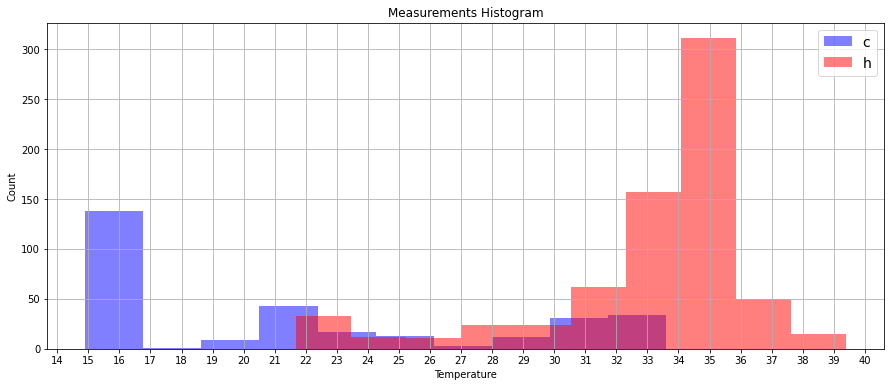

In [320]:
# Visualize Temperature Histograms
plot_hist([c_pd, h_pd], ["c_tmp", "h_tmp"], bins=None, xlabel="Temperature", labels=["c", "h"], colors=["blue", "red"])

### Time Evolution of the Cooling and Heating temperatures

In [321]:
# Convert spark to pandas dataframe
ch_pd = ch_series.toPandas()
# Convert time to integer column
ch_pd["time"] = ch_pd["time"].apply(lambda x: float(x.replace(":", ".")))

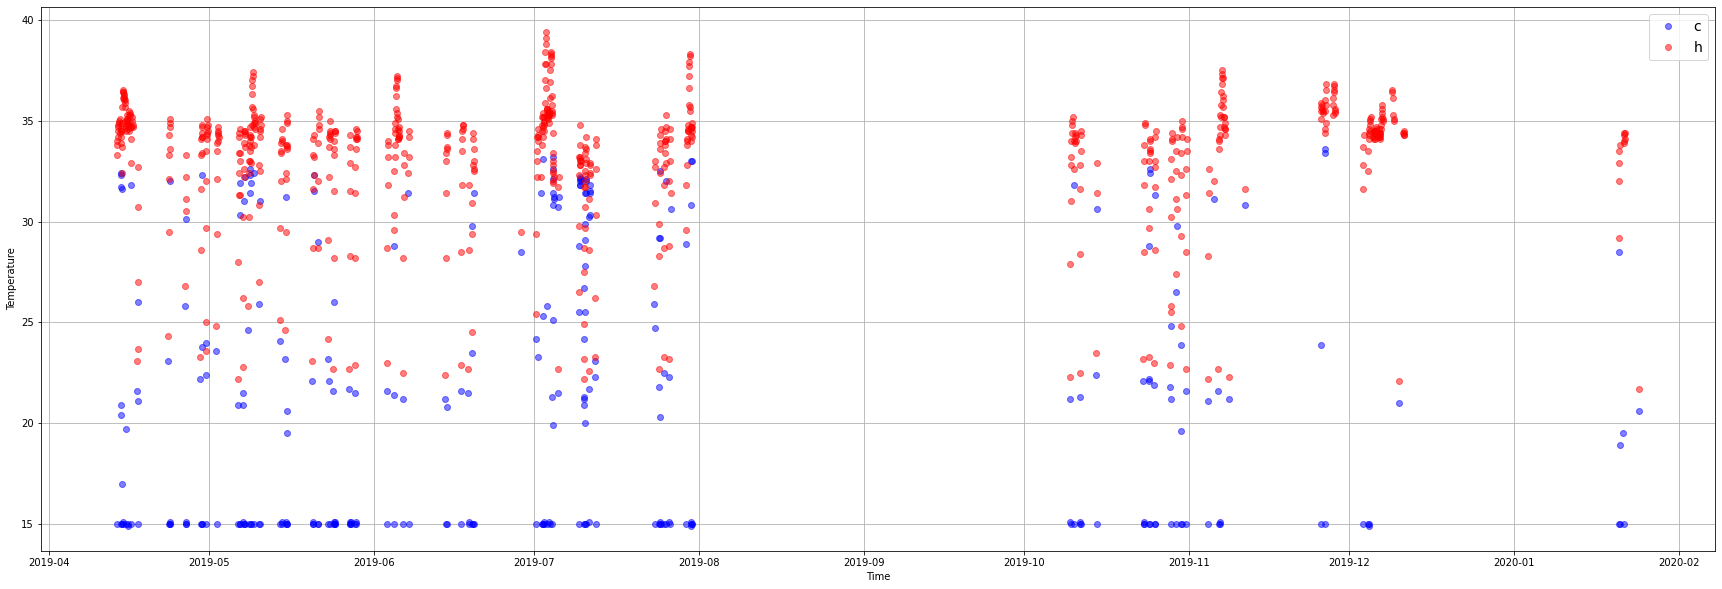

In [323]:
plot_series([ch_pd, ch_pd], ["datetime", "datetime"], ["c_tmp", "h_tmp"])

❌ We can notice already a big gap of two moths between 2019-08 and 2019-10. We miss a considerable time frame considering that the timestamps have a resolution of the second and can differ by few minutes.

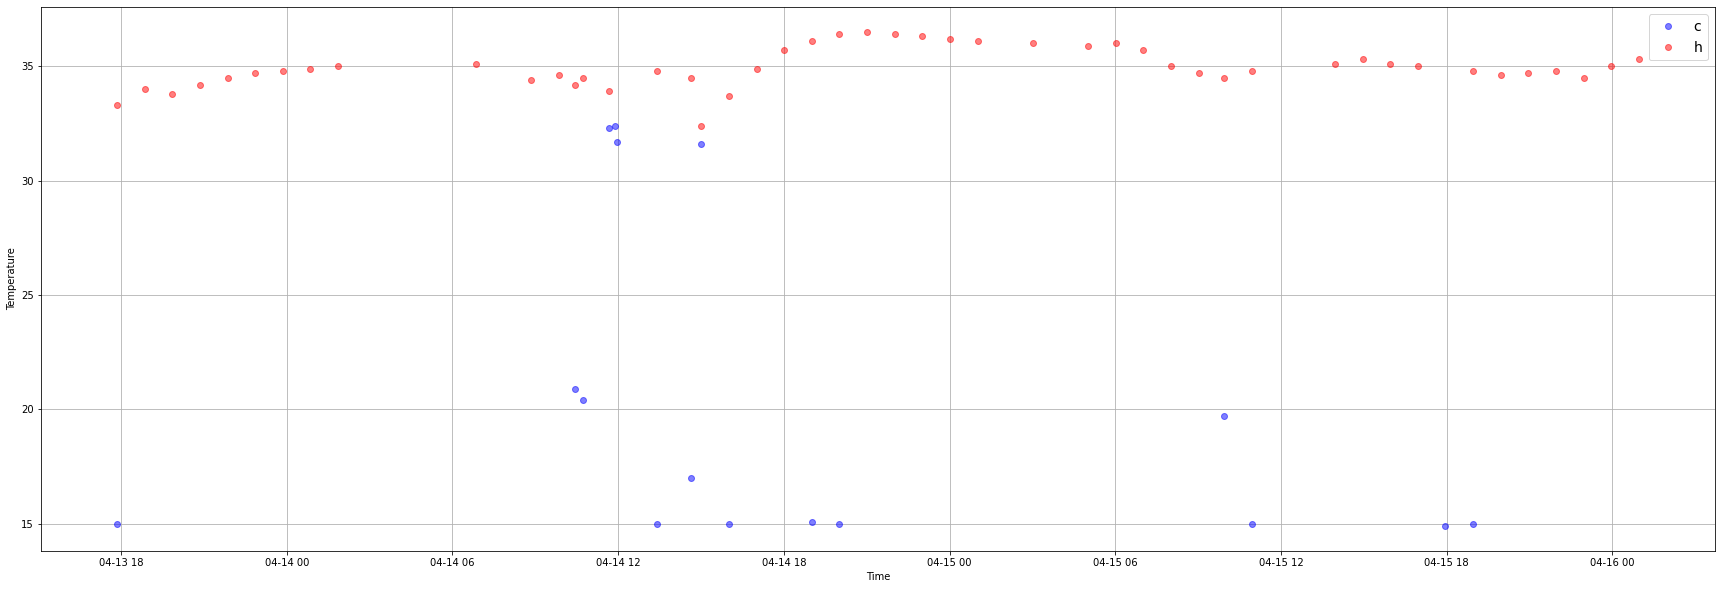

In [324]:
# Plot time series
plot_series([ch_pd, ch_pd], ["datetime", "datetime"], ["c_tmp", "h_tmp"], start=0, end=50)

⭐ We can notice that measurements taken with a short time difference (same day, or few hours shift) are not changing drastically. 

Thus a simple approach to replace the missing values close to not missing values could be by taking the previous seen sample (assuming that the anomalies are previously discarded, otherwise we are going to increase their frequency) or an average of the k previous values. 

### Periodicity

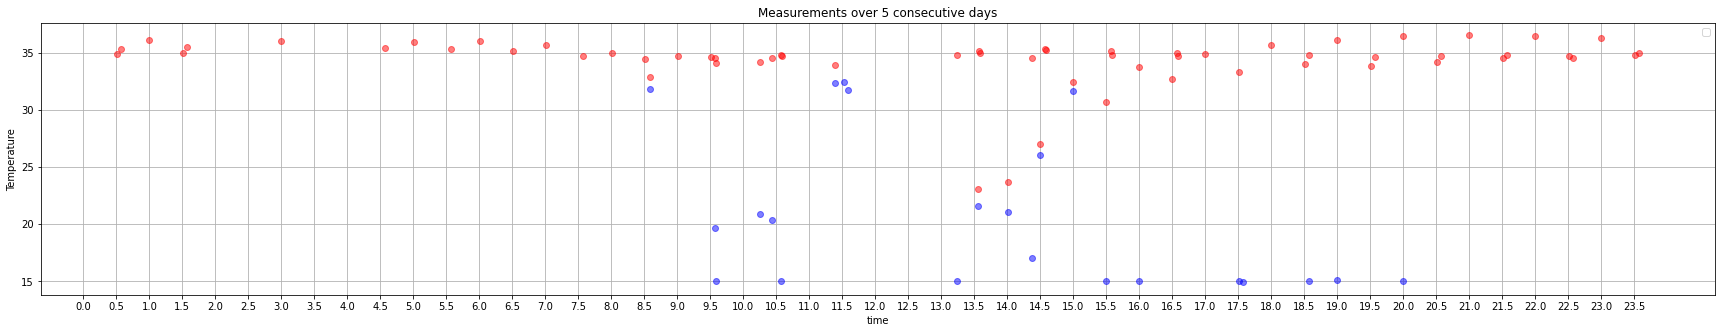

In [325]:
# Plot time series overlapping measurements of several days 
number_dates = 5
dates = ch_pd.date.drop_duplicates()[0:number_dates]
plot_series_over_days(dates, day_column="date", list_serie=[ch_pd, ch_pd], list_tmp=["c_tmp", "h_tmp"], list_time=["time", "time"], 
                          start=0, end=24, format="o", xlabel="Time", ylabel="Temperature", colors=["b", "r"], labels=["c", "h"],
                          figwidth=30, figheight=5, alpha=0.5)

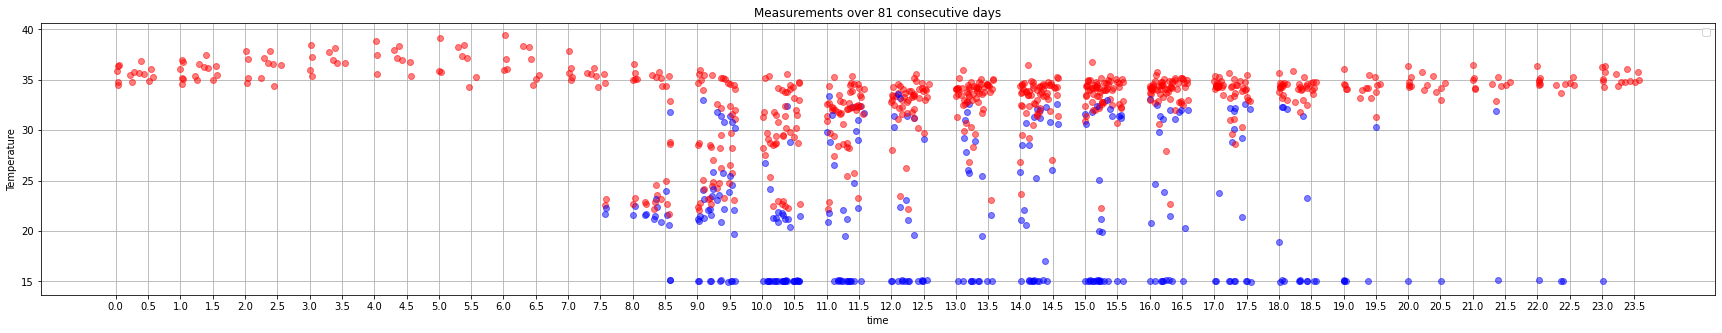

In [326]:
# Plot time series overlapping measurements of several days 
number_dates = None
dates = ch_pd.date.drop_duplicates()[0:number_dates]
plot_series_over_days(dates, day_column="date", list_serie=[ch_pd, ch_pd], list_tmp=["c_tmp", "h_tmp"], list_time=["time", "time"], 
                          start=0, end=24, format="o", xlabel="Time", ylabel="Temperature", colors=["b", "r"], labels=["c", "h"],
                          figwidth=30, figheight=5, alpha=0.5)

⭐ We can notice that measurements have a periodicity. It seems that every hour the pattern is repeating.
 
❌ Moreover we see that before 7 am we do not have cooling temperature measurements and the heating temperature is higher (above 35°).

⁉ **My thoughts**:
- Why do we not have measurements of the cooling temperature before 7 am? Could it be that in the early morning/night the system is not used or can stay at a warm temperature while it needs to be cooled during the day? 
- Is it an anomaly? Is the sensor down in the early morning?

⚠ **Assumption**:
I will assume that the sensor is not recording cooling temperatures before 6 am because of an error in the system. Looking at the data I will assume that the behaviour of the system between midnight and 7 am is the same as the one after 7 pm.







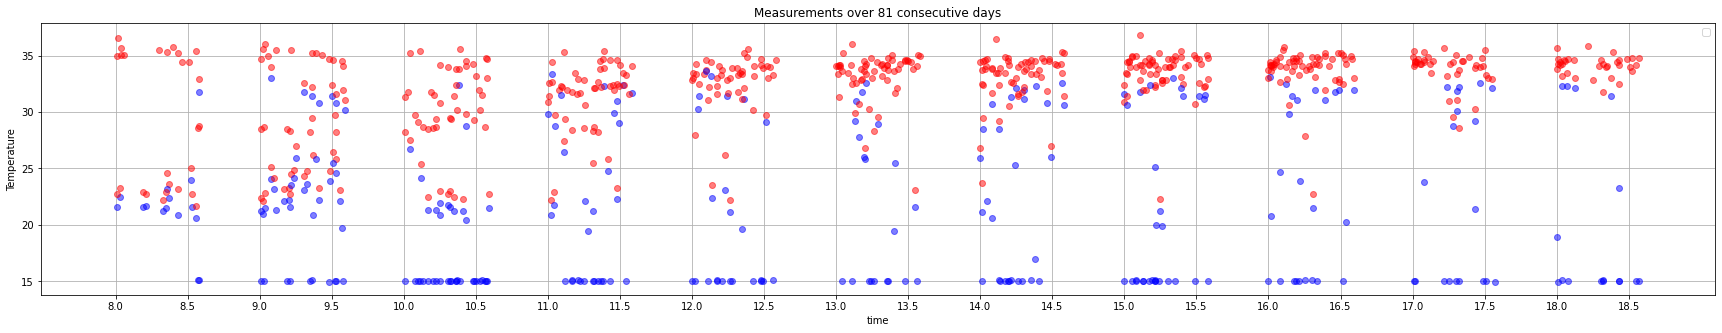

In [327]:
# Plot time series overlapping measurements of several days 
start=8
end=19
number_dates = None
dates = ch_pd.date.drop_duplicates()[0:number_dates]
plot_series_over_days(dates, day_column="date", list_serie=[ch_pd, ch_pd], list_tmp=["c_tmp", "h_tmp"], list_time=["time", "time"], 
                          start=start, end=end, format="o", xlabel="Time", ylabel="Temperature", colors=["b", "r"], labels=["c", "h"],
                          figwidth=30, figheight=5, alpha=0.5)

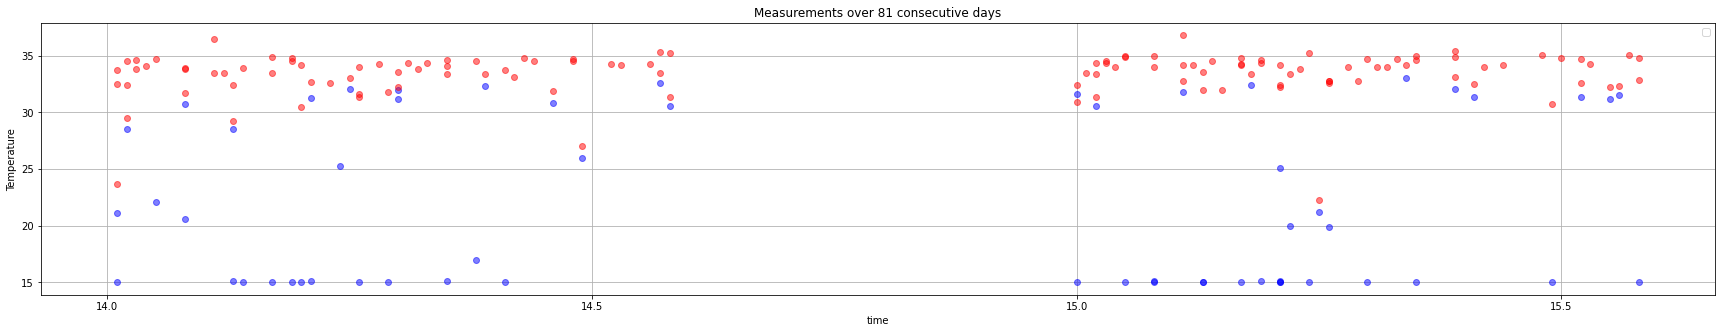

In [328]:
# Plot time series overlapping measurements of several days 
start=14
end=16
number_dates = None
dates = ch_pd.date.drop_duplicates()[0:number_dates]
plot_series_over_days(dates, day_column="date", list_serie=[ch_pd, ch_pd], list_tmp=["c_tmp", "h_tmp"], list_time=["time", "time"], 
                          start=start, end=end, format="o", xlabel="Time", ylabel="Temperature", colors=["b", "r"], labels=["c", "h"],
                          figwidth=30, figheight=5, alpha=0.5)

⭐ Between 9 am and 7 pm we can see that the measurements are taken in the first half an hour and that in the majority of the cases (where more dots are overlapping and are darker) the cooling temperature is really low (15°) and the heating temperature is really high (35°). 

### Heating Temperature and Cooling Temperature Relation

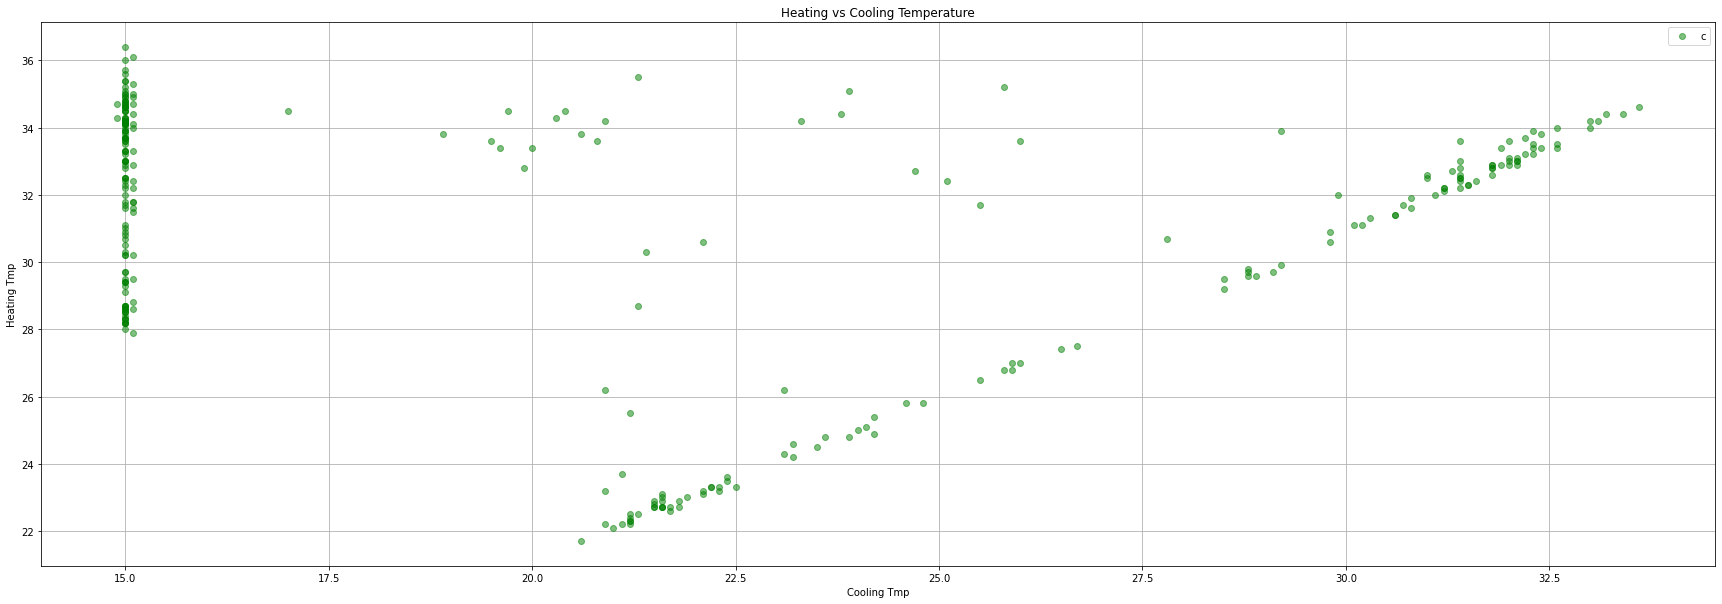

In [329]:
# Plot h_tmp vs c_tmp
start=0
end=None
plt.figure(figsize=(30, 10))
plt.plot(ch_pd.c_tmp[start:end], ch_pd.h_tmp[start:end], 'o', color='g', label='c', alpha=0.5)
plt.title('Heating vs Cooling Temperature')
plt.ylabel('Heating Tmp')
plt.xlabel('Cooling Tmp')
plt.legend()
plt.grid(True)
plt.show()

✨ By considering only the measurements that recorded both heating and cooling temperatures (about half dataset), and excluding the  temporal information, I can see two/three strong behaviours (values are approximated for simplicity):
- if c_tmp ≃ 15°, 28° ≤ h_tmp ≤ 36°
- if 16° ≤ c_tmp ≤ 20°,  32° ≤ h_tmp ≤ 36° (transition phase)
- if c_tmp > 20, h_tmp ≃ c_tmp (linear relationship - the higher the cooling temperature, the lower the heating temperature is)

⁉ **My thoughts**:

The two measurements seems to record the temperature of two measurement points of the same system (I guess energy transfer by heating from a hotter to a cooler region). 

At this point my questions are:
- What shall I consider as anomalies? Are they anomal combinations of heating and cooling temperatures (heating and cooling temperature that do not respect the relation showed above, or cooling temperatures higher than heating temperature, ...)? Or are they anomal values of the uni-variate time series (cooling or heating temperatures that different significantly and have a high standard deviation of the sample)?
- Do I need to fill the missing values to find the anomalies? Or can I figure them out by using defined rules according to the common behaviours seen above (e.g.: all the points that are not belonging to the main two lines)?

⚠ **Assumption**:
Assuming that the assignment is strongly focused on the handling of missing values, I will propose an approach to have an aproximately clean multi-variate time series, sampled at a constant sampling period. Afterwards, this cleaned and uniformally sampled time series can be used to perform anomaly detection in at least in two ways:
1. fitting a time series forecast model and identifying confidence intervals. 
2. creating previous observations or new variables as predictors and apply clusterign algorithms to differentiate normal values from outliers.


### Find the most promising sampling period

Before we saw a periodicity on a hourly base. But I want to double check by looking at the time difference between the timestamps of the two univariate time series.

In [331]:
# Check Periodicity of the measurements for the two temperatures
windowSpec = Window.partitionBy().orderBy("datetime")
ch_timestamps = ch_series.select("datetime").withColumn("next_timestamp", lag("datetime",-1).over(windowSpec))
ch_timestamps = ch_timestamps.na.drop() # remove last row without next timestamp
ch_timestamps = ch_timestamps.withColumn("diff_sec", col("next_timestamp").cast("long") - col("datetime").cast("long"))
ch_timestamps = ch_timestamps.withColumn("diff_min", round((col("next_timestamp").cast("long") - col("datetime").cast("long"))/60)) # round minutes to reduce the numbe of distinct values
# check most frequent timegap
ch_timestamps.select("diff_min").agg(mean(col("diff_min")), min(col("diff_min")), max(col("diff_min"))).show()
timestamp_gap_frequency = ch_timestamps.select("diff_min").groupBy("diff_min").count().sort(col("count").desc())
timestamp_gap_frequency = timestamp_gap_frequency.withColumn("percentage", round(col("count")/ch_series.count()*100, 2))
timestamp_gap_frequency.show(n=20)

+-----------------+-------------+-------------+
|    avg(diff_min)|min(diff_min)|max(diff_min)|
+-----------------+-------------+-------------+
|575.2223776223776|          4.0|     102170.0|
+-----------------+-------------+-------------+

+--------+-----+----------+
|diff_min|count|percentage|
+--------+-----+----------+
|    60.0|  507|     70.81|
|   120.0|   21|      2.93|
|   180.0|    7|      0.98|
|    25.0|    4|      0.56|
|    12.0|    4|      0.56|
|    56.0|    4|      0.56|
|    21.0|    4|      0.56|
|    37.0|    3|      0.42|
|    18.0|    3|      0.42|
|     6.0|    3|      0.42|
|    15.0|    3|      0.42|
|    28.0|    3|      0.42|
|    48.0|    3|      0.42|
|    62.0|    2|      0.28|
|    20.0|    2|      0.28|
|    31.0|    2|      0.28|
|    71.0|    2|      0.28|
|    67.0|    2|      0.28|
|    24.0|    2|      0.28|
|    30.0|    2|      0.28|
+--------+-----+----------+
only showing top 20 rows



It is clear that the most frequent sampling period is every hour (for approx. 74% of the obeservations, if we consider also the multiple of 60 minutes). The problem is that the from day to day these hourly measurements are delayed of several minutes (that's why we see so many measurements in the first half an hour). Moreover we we have also cases in which the measuremntes are taken more frequently or less frequently. 

⚠ **Assumption**:
I will assume that the sampling period is equal to one hour and that the sensor has a clock misfunction.



---



# 2. Interpolation

## Sample Uniformly the time series by averaging measurements 

In [333]:
# Create Spark dataframe with all possible timestamps in the time series range
timeline = generate_series("2019-04-13 17:00:00", "2020-01-24 09:00:00", 60*60)
check_count_rows(timeline, 6856)
# Add hour column
sampled_ch_series = ch_series.withColumn("hour", date_trunc("hour", "datetime"))
# Average measurements in the same hour
group = Window.partitionBy("hour")
sampled_ch_series = sampled_ch_series.withColumn("avg_c_tmp", round(mean("c_tmp").over(group),1)).withColumn("avg_h_tmp", round(mean("h_tmp").over(group),1))
# Add timestamps that are missing to get a uniform sampled time series
sampled_ch_series = sampled_ch_series.select("hour", "avg_c_tmp", "avg_h_tmp").dropDuplicates()
filled_ch_series_with_na = sampled_ch_series.join(timeline, sampled_ch_series['hour'] == timeline['uniform_datetime'], 'outer').select(col("uniform_datetime").alias("hour"), "avg_c_tmp", "avg_h_tmp")
# Check if join is correct
check_count_rows(filled_ch_series_with_na, timeline.count())
# Display uniform sampled time series
filled_ch_series_with_na.show()

+-------------------+---------+---------+
|               hour|avg_c_tmp|avg_h_tmp|
+-------------------+---------+---------+
|2019-04-13 17:00:00|     15.0|     33.3|
|2019-04-13 18:00:00|     null|     34.0|
|2019-04-13 19:00:00|     null|     33.8|
|2019-04-13 20:00:00|     null|     34.2|
|2019-04-13 21:00:00|     null|     34.5|
|2019-04-13 22:00:00|     null|     34.7|
|2019-04-13 23:00:00|     null|     34.8|
|2019-04-14 00:00:00|     null|     34.9|
|2019-04-14 01:00:00|     null|     35.0|
|2019-04-14 02:00:00|     null|     null|
|2019-04-14 03:00:00|     null|     null|
|2019-04-14 04:00:00|     null|     null|
|2019-04-14 05:00:00|     null|     null|
|2019-04-14 06:00:00|     null|     35.1|
|2019-04-14 07:00:00|     null|     null|
|2019-04-14 08:00:00|     null|     34.4|
|2019-04-14 09:00:00|     null|     34.6|
|2019-04-14 10:00:00|     20.7|     34.4|
|2019-04-14 11:00:00|     32.1|     33.9|
|2019-04-14 12:00:00|     null|     null|
+-------------------+---------+---

## Remove outliers

⁉ **My thoughts**:

Before replacing the missing values with existing ones we need to remove the outliers, otherwise the anomalies will be replicated over different timestamps. 

In this case I would apply a hard coded rule or a clustering algorithm (e.g., k-means, DBSCAN) to filter out the values that do not belong to the two rects: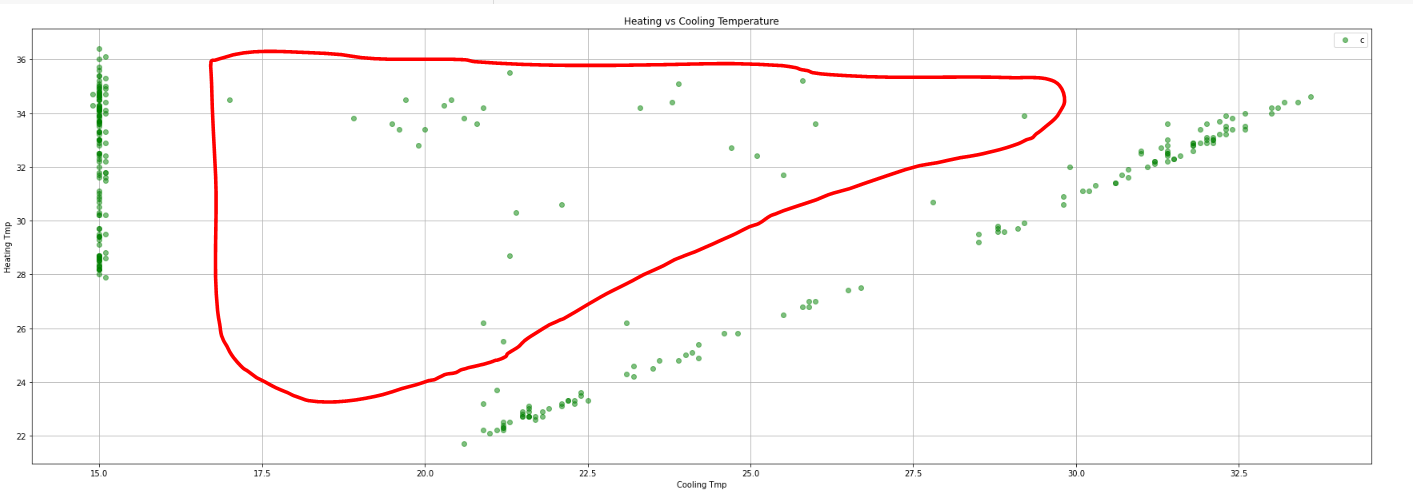 

⚠ **Assumption**:
I am not going to do it now, because I am running out of time.

## Apply interpolation techniques to fill the Nulls

⁉ **My thoughts**:

Low-cost and baseline methods for imputing unobserved data by predicting the current datapoint given past observations are:
- constant propagation (missing value is most recent observed value)
- averaging (mean imputation, average of k most recent observations)
- window averaging (arbitrary window before missing value)
- linear propagation (fit a line to most recent k observations and uses a linear funtion as a predictor for the future)
- splines - B-splines (piecewise polynomial functions that can either interpolate or smooth irregurarly sample data)
- ARMA Modeling
- Kalman Filter
- combinations of previous methods

These models all assume that adjacent data points are similar, that in this case could work.

To replace the big holes (missing months), I need a model that is approximating the time series and predicting the missing values. I do not expect to get a good approximation because the model will need to predict missing values from previous predictions and not from actual values (predictions error are accumulating). Luckly the time series is repeating its pattern thus we know what to expect in the missing months but if possible I would try to ask more data to the data owner.


⚠ **Assumption**:

My approach to solve the assignment would be:

1. Get one interpolated time series in the following way:
- if I have at least one temperature value not null (or cooling or heating temperature) then I replace the missing temperature according to the relation it has with the other temperature as described before.
- if I do not have any temperature values, then I replace them with the ones of the previous timestamp.
- it I do not have any temperature values for consecutive timestamps, then I replace the missing values with the temperature values of the previous day.
- to cover the gaps of one or several months, then I replace the gap with an average pattern over the previous populated months.

2. Get one interpolated time series using a Kalman filter or any kind of model that can handle missing values.

3. Compare the two versions and pick the best one by comparing proper metrics
  (MAE, RMSE, R2, ...) evaluated on the available measurements.

Due to the fact that I am running out of time I am gonna check only simple interpolation methods already implemented in scikit learn and scipy that are out of the box.

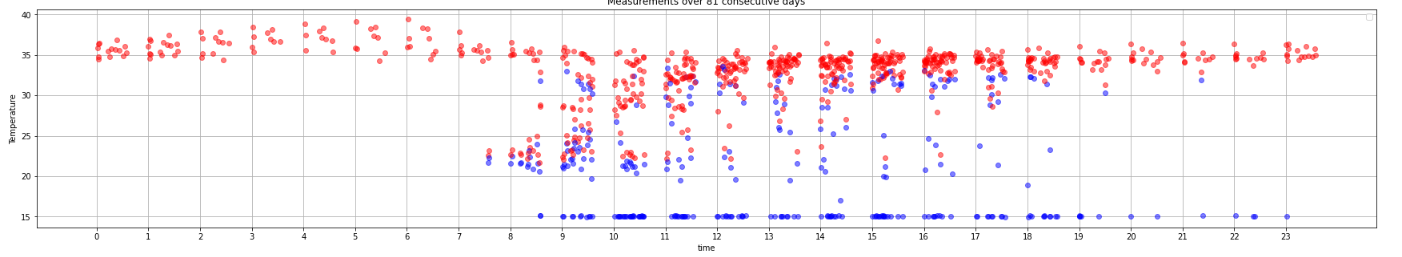

Just to see what it happens if I use a basic interpolation method using scikit learn library:

In [334]:
# Convert to pandas dataframe
uniform_ch_pd = filled_ch_series_with_na.toPandas()

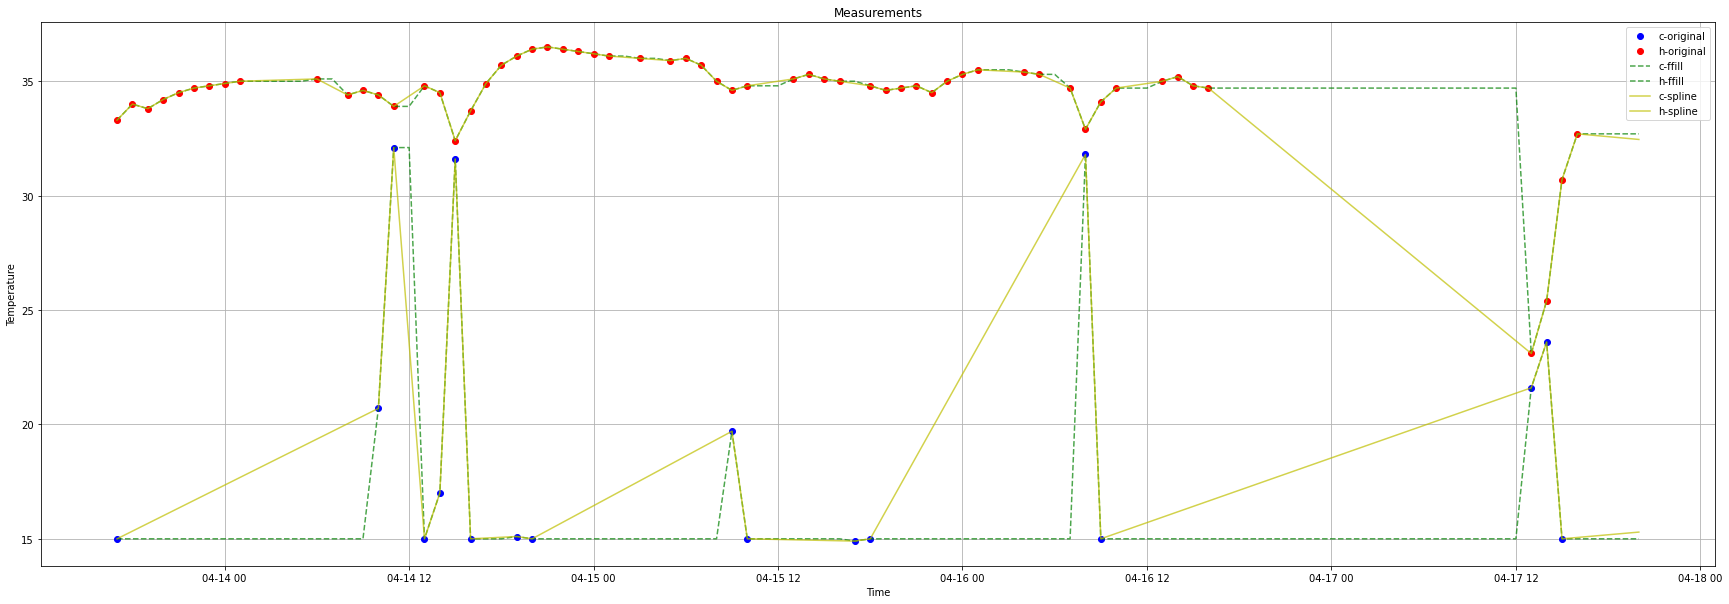

In [336]:
# Impute the missing value with the previous value
ffill_uniform_ch_pd = uniform_ch_pd.copy()
cubic_spline_uniform_ch_pd = uniform_ch_pd.copy()

for type_tmp in ["avg_c_tmp", "avg_h_tmp"]:
  ffill_uniform_ch_pd[type_tmp].ffill(limit=None, inplace=True) # forward fill , use (limit=6, inplace=True) to limit up to 6h
  cubic_spline_uniform_ch_pd[type_tmp]= cubic_spline_uniform_ch_pd[type_tmp].interpolate(option="cubicspline") #spline, order=2
  # uniform_ch_pd[type_tmp].bfill(limit=None, inplace=True) # backward fill up
start=0
end=100
plt.figure(figsize=(30, 10))
# original values
plt.plot(uniform_ch_pd.hour[start:end], uniform_ch_pd.avg_c_tmp[start:end], 'ro', color='b', label='c-original', alpha=1)
plt.plot(uniform_ch_pd.hour[start:end], uniform_ch_pd.avg_h_tmp[start:end], 'ro', color='r', label='h-original', alpha=1)
# forward fill
plt.plot(ffill_uniform_ch_pd.hour[start:end], ffill_uniform_ch_pd.avg_c_tmp[start:end], '--', color='g', label='c-ffill', alpha=0.7)
plt.plot(ffill_uniform_ch_pd.hour[start:end], ffill_uniform_ch_pd.avg_h_tmp[start:end], '--', color='g', label='h-ffill', alpha=0.7)
# 
plt.plot(cubic_spline_uniform_ch_pd.hour[start:end], cubic_spline_uniform_ch_pd.avg_c_tmp[start:end], '-', color='y', label='c-spline', alpha=0.7)
plt.plot(cubic_spline_uniform_ch_pd.hour[start:end], cubic_spline_uniform_ch_pd.avg_h_tmp[start:end], '-', color='y', label='h-spline', alpha=0.7)
plt.title('Measurements')
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

# 3. Apply Detection Algorithm
After cleaning the time series I would finally apply an anomaly detection algorithm. Some unsupervised methods that come to my mind are:
- Subspace Projection (PCA) 
- Isolation forest - IF (close cousin of random forest)
- One Class SVM
- LSTM
- ... 